In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from src.densenet.densenet import CustomDenseNet
from src.densenet.runtime_transforms import RuntimeTransforms
import os
import glob
from PIL import Image
from tqdm import tqdm
from src.densenet.compute_mAP import compute_mAP_for_ks_numpy
import datetime

demonstration of using the reid model to extract features from images
and then query the database for similar images

In [2]:
path_model = os.path.join('..', '..', 'evaluations', 'mAP_summary_stats', '2024-06-01-14-46-00',
                          'P.helianthoides', 'Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-18-41__best_densenet121__PT-True.pth')
os.path.exists(path_model)

True

In [3]:
path_dataset = os.path.join('..','..','data', os.path.basename(path_model).split('__')[0])
os.path.exists(path_dataset)

True

In [4]:
emb_dim = 256
num_head_layers = 3

model = CustomDenseNet(version='densenet121', pretrained=False,
                           embedding_dim=emb_dim, num_embed_layers=num_head_layers)  # Set pretrained=False as we'll load our weights
# Load the trained weights
model.load_state_dict(torch.load(path_model))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Check if the model has been loaded correctly
model.eval()

CustomDenseNet(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentu

In [5]:
path_gallery = os.path.join(path_dataset, 'train')
print(f'Gallery dataset path: {path_gallery} {os.path.exists(path_gallery)}')

Gallery dataset path: ..\..\data\Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-18-41\train True


In [6]:
path_query = os.path.join(path_dataset, 'test')
print(f'Query dataset path: {path_query} {os.path.exists(path_query)}')

Query dataset path: ..\..\data\Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-18-41\test True


In [7]:
def get_id (path):
        return os.path.basename(os.path.dirname(path))

path_gallery_images = glob.glob(os.path.join(path_gallery, '*/*.png'))
path_gallery_images += glob.glob(os.path.join(path_gallery, '*/*.jpg'))
gallery_ids = [get_id(path) for path in path_gallery_images]

path_query_images = glob.glob(os.path.join(path_query, '*/*.png'))
path_query_images += glob.glob(os.path.join(path_query, '*/*.jpg'))
query_ids = [get_id(path) for path in path_query_images]

ids_dict = {id: i for i, id in enumerate(sorted(list(set(gallery_ids + query_ids))))}
num_dict = {i: id for i, id in enumerate(sorted(list(set(gallery_ids + query_ids))))}

gallery_ids = [ids_dict[id] for id in gallery_ids]
query_ids = [ids_dict[id] for id in query_ids]

print(f'Number of identities: {len(ids_dict)}')
print(f'Number of gallery images: {len(path_gallery_images)}')
print(f'Number of query images: {len(path_query_images)}')

# Initialize the runtime transforms
runtime_transforms = RuntimeTransforms(h=256, w=256, resize_ratio=0.5)

gallery_embeddings = []
pbar = tqdm(total=len(path_gallery_images), position=0, leave=True)
for path in path_gallery_images:
    img = Image.open(path).convert("RGB")
    transformed_images = runtime_transforms.apply_transforms(img) ## returns a list of transformed images

    # Embed all the transformed images at once as a batch
    batch = torch.stack([transformed_image for transformed_image in transformed_images]).to(device)
    with torch.no_grad():
        embeddings = model(batch).cpu().numpy()
    # Average the embeddings
    averaged_embedding = np.mean(embeddings, axis=0)
    gallery_embeddings.append(averaged_embedding)
    pbar.update(1)
pbar.close()

query_embeddings = []
pbar = tqdm(total=len(path_query_images), position=0, leave=True)
for path in path_query_images:
    img = Image.open(path).convert("RGB")
    transformed_images = runtime_transforms.apply_transforms(img)  # Returns a list of transformed images

    # Embed all the transformed images at once as a batch
    batch = torch.stack([transformed_image for transformed_image in transformed_images]).to(device)
    with torch.no_grad():
        embeddings = model(batch).cpu().numpy()

    # Average the embeddings
    averaged_embedding = np.mean(embeddings, axis=0)
    query_embeddings.append(averaged_embedding)
    pbar.update(1)
pbar.close()

# Convert to numpy arrays
gallery_embeddings = np.array(gallery_embeddings)
query_embeddings = np.array(query_embeddings)
gallery_ids = np.array(gallery_ids)
query_ids = np.array(query_ids)

Number of identities: 271
Number of gallery images: 5159
Number of query images: 1455


100%|██████████| 1455/1455 [00:55<00:00, 26.27it/s]


Query image: ..\..\data\Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-18-41\test\stella__ADULT_FHL_STARS\P3235563.png


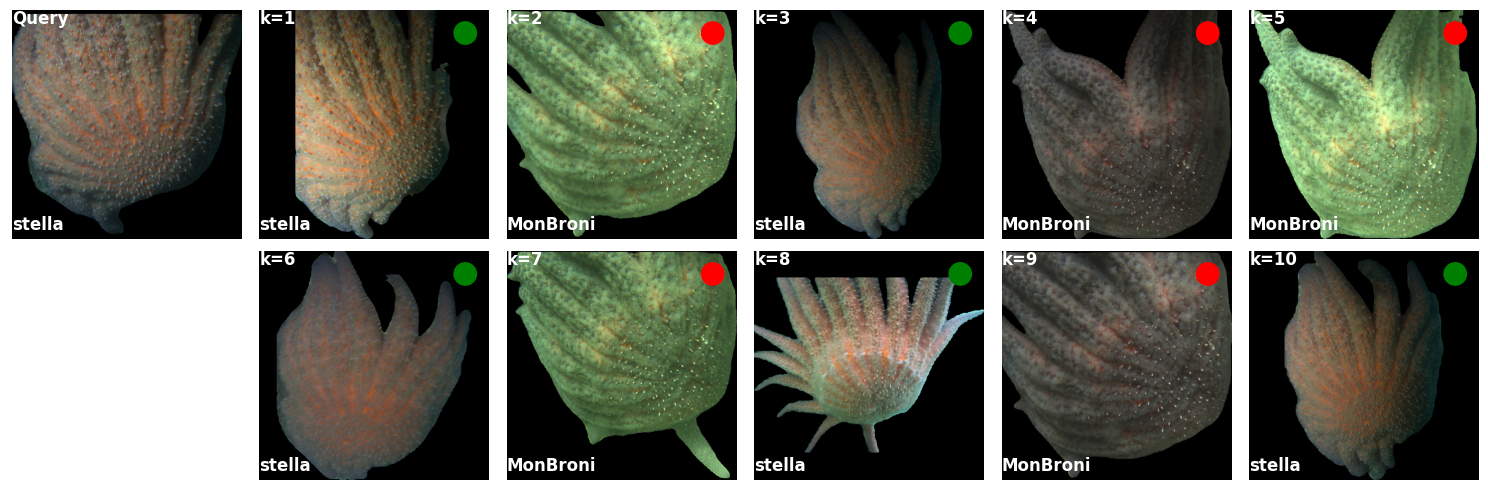

Query image: ..\..\data\Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-18-41\test\muddy__ADULT_FHL_STARS\Muddy.jpg


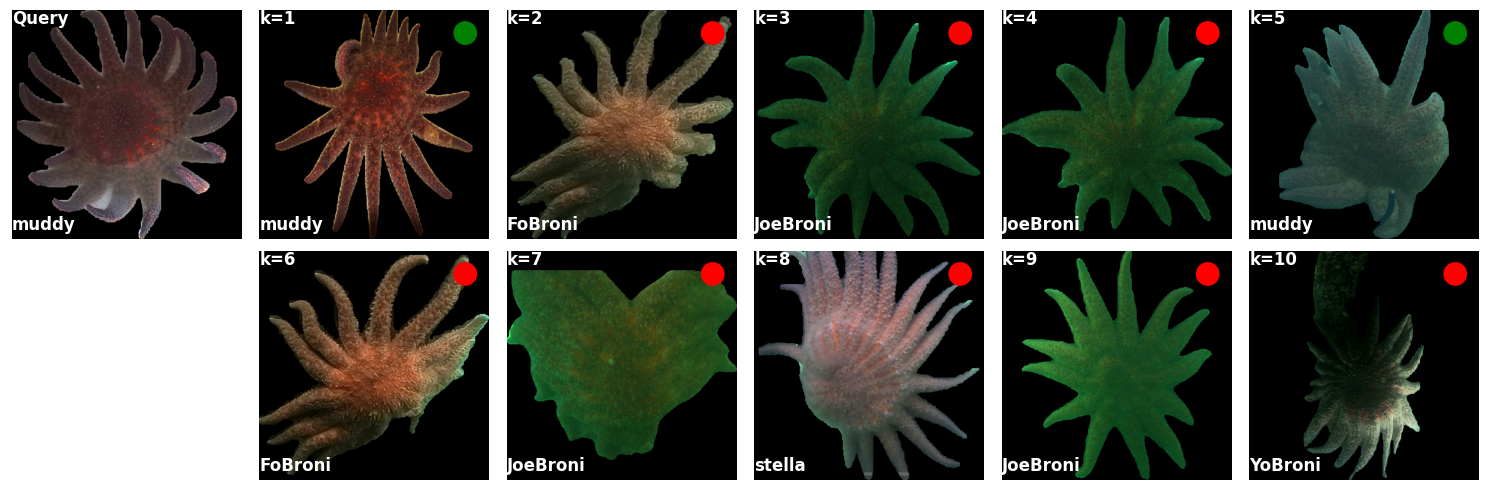

Query image: ..\..\data\Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-18-41\test\crocus__ADULT_FHL_STARS\crocus_1.png


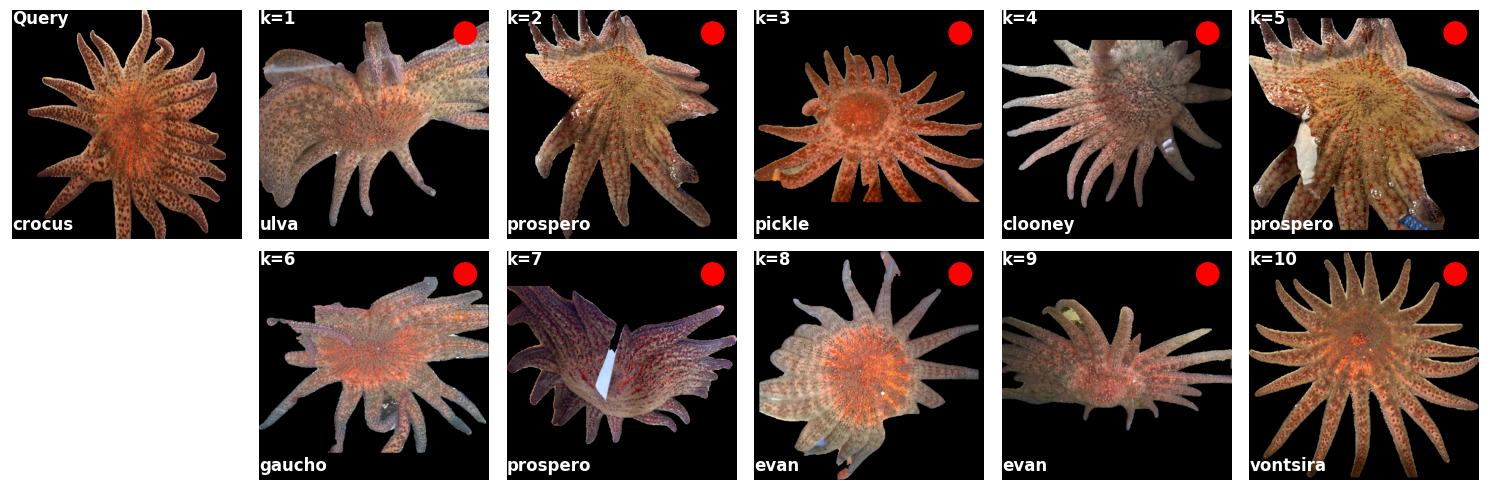

Query image: ..\..\data\Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-18-41\test\gaucho__ADULT_FHL_STARS\P4065598.png


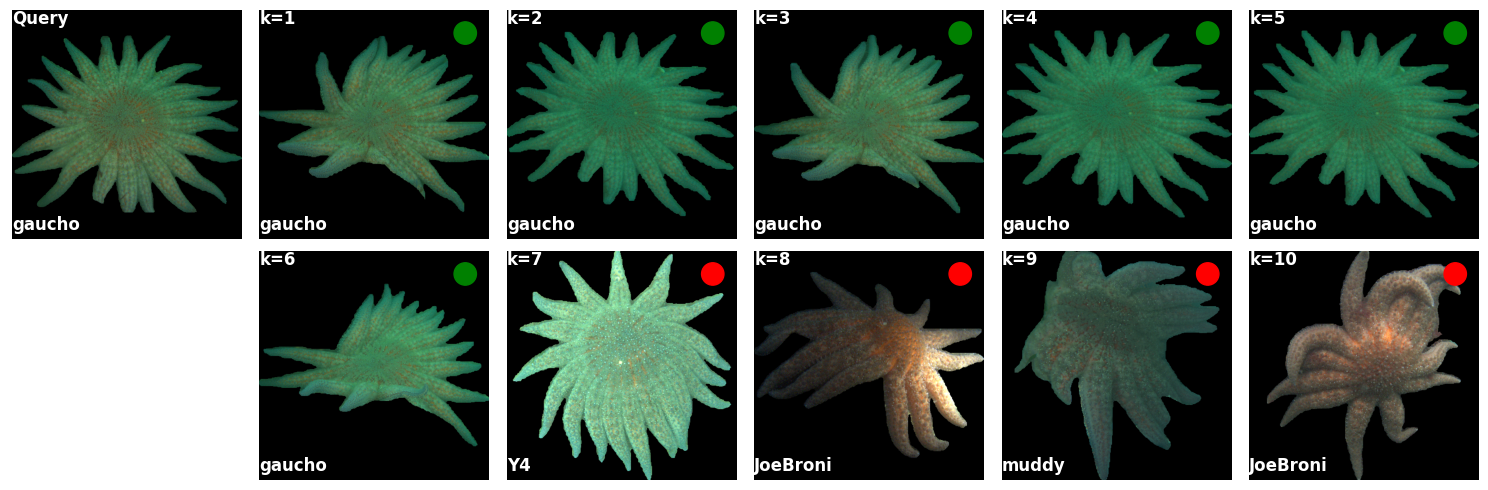

Query image: ..\..\data\Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-18-41\test\ursa_minor__ADULT_FHL_STARS\Ursa Minor.png


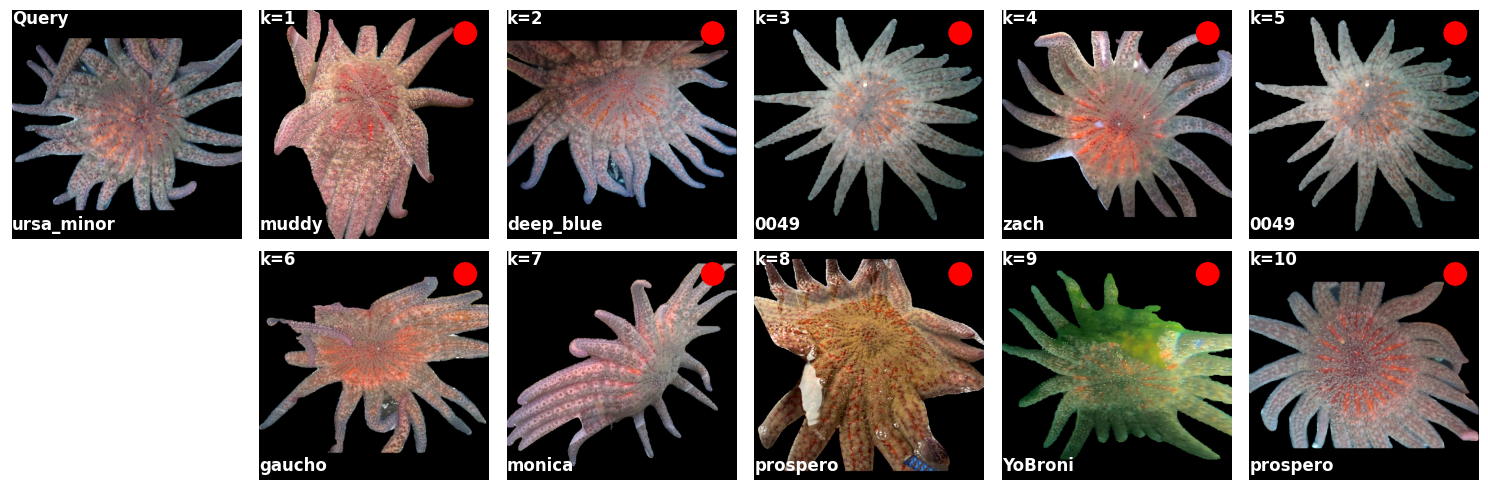

Query image: ..\..\data\Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-18-41\test\0091__PWS_2023\DSC_4356.png


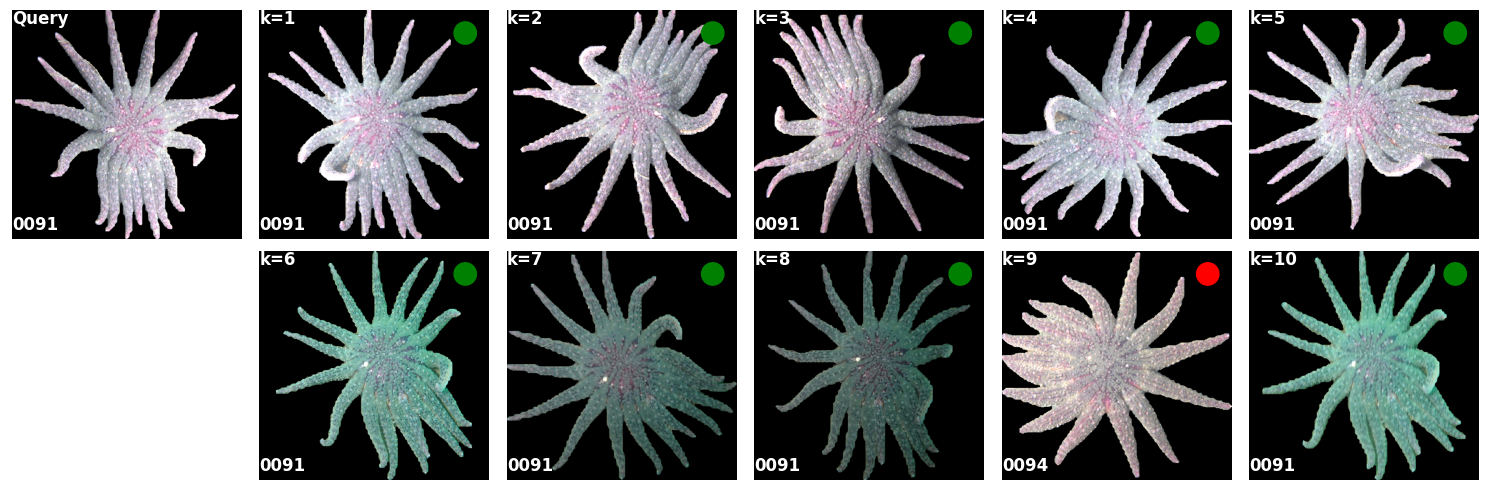

Query image: ..\..\data\Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-18-41\test\r1w3__wild_stars_cama_beach_pycno_pre_deployment\DSC_1593.png


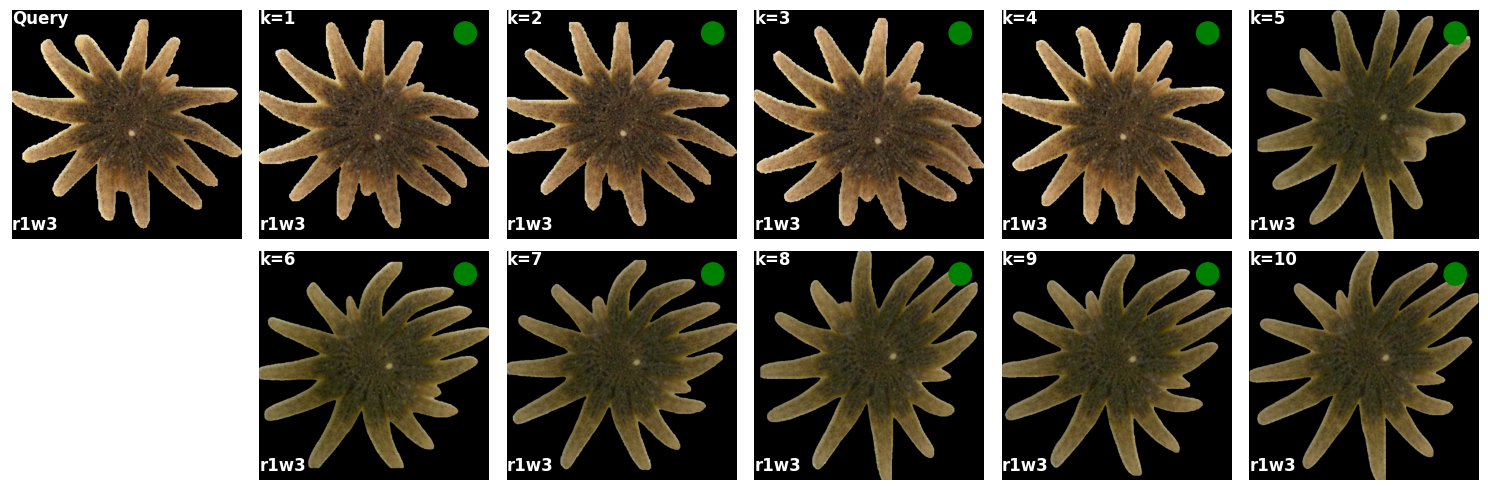

Query image: ..\..\data\Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-18-41\test\b2z1__lab_stars_pycno_deployment\160__b2z1.png


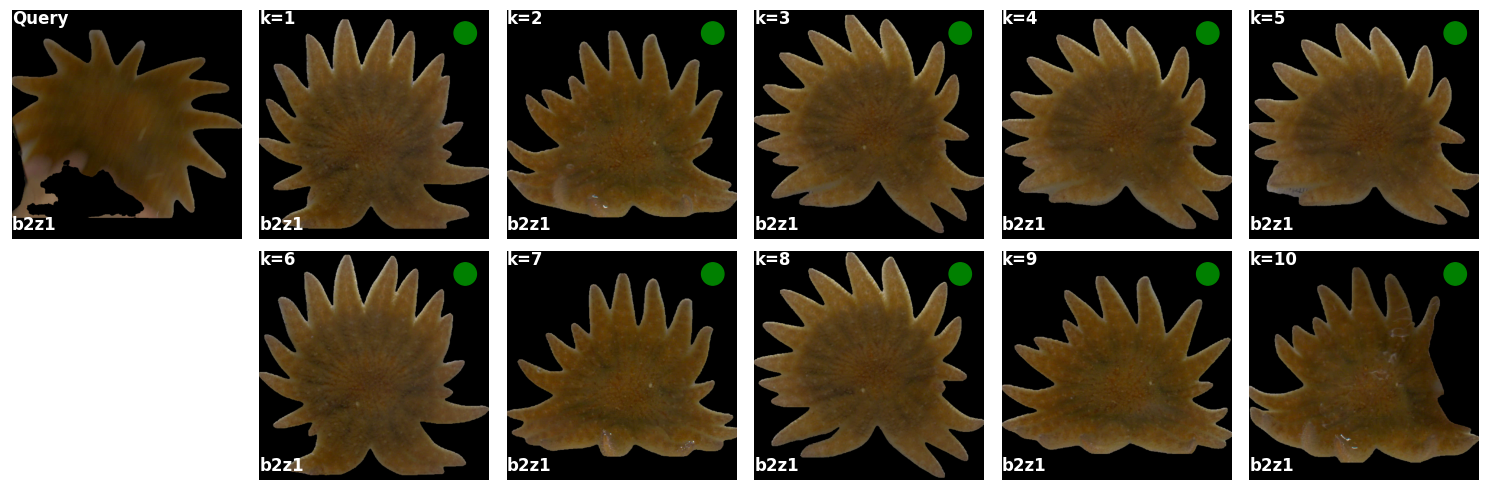

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances
from PIL import Image
import os

def plot_query_and_top_k_images(plot_dir, query_embeddings, gallery_embeddings, path_query_images, path_gallery_images, k=10, query_path_contains='ADULT'):
    """
    Plots the query image and top k closest images from the gallery based on euclidean distance.

    Parameters:
        query_embeddings (np.ndarray): Embeddings for the query images.
        gallery_embeddings (np.ndarray): Embeddings for the gallery images.
        path_query_images (list): List of file paths for the query images.
        path_gallery_images (list): List of file paths for the gallery images.
        k (int): Number of top images to retrieve and display.
        query_path_contains (str): String that the query image path must contain.
    """

    # Prune possible queries to include only those that contain the specified string
    possible_query_indices = [i for i, path in enumerate(path_query_images) if query_path_contains in path]

    if not possible_query_indices:
        raise ValueError(f"No query images found containing the string '{query_path_contains}'")

    # Select a random query index from the possible choices
    query_index = np.random.choice(possible_query_indices)

    # Compute the pairwise euclidean distances
    distances = pairwise_distances(query_embeddings[query_index].reshape(1, -1), gallery_embeddings, metric='euclidean')
    top_k_indices = np.argsort(distances, axis=1)[0][:k]

    path_query = path_query_images[query_index]
    name_query = os.path.basename(os.path.dirname(path_query)).split('__')[0]
    print(f'Query image: {path_query}')

    # Plot the query image and the top k images
    fig, ax = plt.subplots(2, (k // 2) + 1, figsize=(int(k * 1.5), 5))

    # Display the query image
    query = Image.open(path_query)
    h, w = query.size
    ax[0, 0].imshow(query)
    text = 'Query'
    ax[0, 0].text(0, 0, text, color='white', fontsize=12, fontweight='bold', verticalalignment='top', horizontalalignment='left')
    text = f'{name_query}'
    ax[0, 0].text(0, int(h * (9 / 10)), text, color='white', fontsize=12, fontweight='bold', verticalalignment='top', horizontalalignment='left')
    ax[0, 0].axis('off')

    # Leave the blank space
    ax[1, 0].axis('off')

    # Display the top k images
    for i, index in enumerate(top_k_indices):
        row = i // (k // 2)
        col = i % (k // 2) + 1
        gallery = Image.open(path_gallery_images[index])
        h, w = gallery.size
        name_gallery = os.path.basename(os.path.dirname(path_gallery_images[index])).split('__')[0]
        ax[row, col].imshow(gallery)
        text = f'k={i + 1}'
        ax[row, col].text(0, 0, text, color='white', fontsize=12, fontweight='bold', verticalalignment='top', horizontalalignment='left')
        ax[row, col].axis('off')
        text = f'{name_gallery}'
        ax[row, col].text(0, int(h * (9 / 10)), text, color='white', fontsize=12, fontweight='bold', verticalalignment='top', horizontalalignment='left')

        # if name_query == name_gallery add a green circle in the upper right corner else make it red
        if name_query == name_gallery:
            color = 'green'
        else:
            color = 'red'

        circle = plt.Circle((int(w * (9 / 10)), int(h / 10)),
                            min(h, w) // 20, fill=True, color=color)
        ax[row, col].add_artist(circle)


    # Ensure all subplots are turned off
    for a in ax.flat:
        a.axis('off')

    plt.tight_layout()

    name_plot = name_query + '__' + os.path.basename(path_query).split('.')[0]
    path_plot = os.path.join(plot_dir, f'{name_plot}.png')
    plt.savefig(path_plot, bbox_inches='tight', dpi=300)

    plt.show()
    plt.close()

plot_dir = os.path.dirname(path_model)
n_examples = 1
k=10
for n in range(n_examples):
    plot_query_and_top_k_images(plot_dir, query_embeddings, gallery_embeddings, path_query_images, path_gallery_images, k=k, query_path_contains='stella')
    plot_query_and_top_k_images(plot_dir, query_embeddings, gallery_embeddings, path_query_images, path_gallery_images, k=k, query_path_contains='muddy')
    plot_query_and_top_k_images(plot_dir, query_embeddings, gallery_embeddings, path_query_images, path_gallery_images, k=k, query_path_contains='crocus')
    plot_query_and_top_k_images(plot_dir, query_embeddings, gallery_embeddings, path_query_images, path_gallery_images, k=k, query_path_contains='gaucho')
    plot_query_and_top_k_images(plot_dir, query_embeddings, gallery_embeddings, path_query_images, path_gallery_images, k=k, query_path_contains='ursa_minor')
    plot_query_and_top_k_images(plot_dir, query_embeddings, gallery_embeddings, path_query_images, path_gallery_images, k=k, query_path_contains='PWS_2023')
    plot_query_and_top_k_images(plot_dir, query_embeddings, gallery_embeddings, path_query_images, path_gallery_images, k=k, query_path_contains='wild_stars_cama_beach_pycno_pre_deployment')
    plot_query_and_top_k_images(plot_dir, query_embeddings, gallery_embeddings, path_query_images, path_gallery_images, k=k, query_path_contains='lab_stars_pycno_deployment')

In [ ]:
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.metrics import pairwise_distances
from tqdm import tqdm
import os
from PIL import Image
import random
import multiprocessing as mp

def calculate_average_locations(embeddings, ids):
    unique_ids = set(ids)
    avg_locations = {}
    for unique_id in unique_ids:
        indices = [i for i, id_ in enumerate(ids) if id_ == unique_id]
        avg_locations[unique_id] = np.mean(embeddings[indices], axis=0)
    return avg_locations

def compute_absolute_distances_to_avg_location(embeddings, avg_location):
    distances = np.abs(pairwise_distances(embeddings, avg_location.reshape(1, -1), metric='euclidean'))
    return distances.flatten()

def get_plotting_kde_params(distances_id, distances_non_id):
    kde_id = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(distances_id[:, None])
    kde_non_id = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(distances_non_id[:, None])

    x_d = np.linspace(0, np.max([distances_id.max(), distances_non_id.max()]), 1000)
    log_dens_id = kde_id.score_samples(x_d[:, None])
    log_dens_non_id = kde_non_id.score_samples(x_d[:, None])

    return x_d, np.exp(log_dens_id), np.exp(log_dens_non_id)

def process_id_kde(params):
    id_, distances_id, distances_non_id = params
    return id_, get_plotting_kde_params(np.array(distances_id), np.array(distances_non_id))

def prune_ids(avg_locations, num_ids):
    """Randomly prune the IDs to a specified number."""
    pruned_ids = random.sample(list(avg_locations.keys()), min(num_ids, len(avg_locations)))
    return pruned_ids

def analyze_distances_for_all_ids(embeddings, ids, num_ids=50):
    avg_locations = calculate_average_locations(embeddings, ids)

    # Prune the number of IDs to num_ids
    pruned_ids = prune_ids(avg_locations, num_ids)

    all_distances = {id_: [] for id_ in pruned_ids}
    non_id_distances = []

    pbar = tqdm(total=len(pruned_ids))
    for id_ in pruned_ids:
        avg_location = avg_locations[id_]
        target_indices = [i for i, id__ in enumerate(ids) if id__ == id_]
        non_target_indices = [i for i in range(len(ids)) if i not in target_indices]

        distances_id = compute_absolute_distances_to_avg_location(embeddings[target_indices], avg_location)
        all_distances[id_] = distances_id

        distances_non_id = compute_absolute_distances_to_avg_location(embeddings[non_target_indices], avg_location)
        non_id_distances.extend(distances_non_id)
        pbar.update(1)
    pbar.close()

    params = [(id_, distances_id, non_id_distances) for id_, distances_id in all_distances.items()]

    # Use multiprocessing to speed up KDE calculation
    with mp.Pool(processes=50) as pool:
        results = list(tqdm(pool.imap(process_id_kde, params), total=len(params)))

    xDs, kde_ids, kde_nonIds = [], [], []
    for id_, kde_result in results:
        xD, kde_id, kde_nonId = kde_result
        xDs.append(xD)
        kde_ids.append(kde_id)
        kde_nonIds.append(kde_nonId)

    return xDs, kde_ids, kde_nonIds


# Combine gallery and query embeddings and IDs for analysis
all_embeddings = np.vstack((gallery_embeddings, query_embeddings))
all_ids = np.hstack((gallery_ids, query_ids))

# Perform the analysis with random pruning to 50 IDs
xDs, kde_ids, kde_nonIds = analyze_distances_for_all_ids(all_embeddings, all_ids, num_ids=50)

  0%|          | 0/50 [00:00<?, ?it/s]